In [539]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

%matplotlib inline

In [555]:
np.random.seed(0)

X, y = make_moons(200, noise=0.2)
ohe = OneHotEncoder(sparse=False)
yohe = ohe.fit_transform(y.reshape(len(y), 1),)

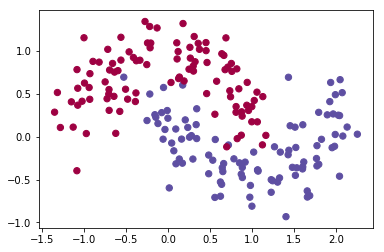

In [556]:
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [561]:
class NeuralNetwork():    
    def __init__(self, 
                 shape, 
                 init_function=NeuralNetwork.randn_initialisation,
                 activation='tanh',
                 output_activation='softmax',
                 loss='categorical_cross_entropy',
                 lr=0.01):
        self.shape = shape
        self.depth = len(shape)
        self.lr = lr
        self.make_weights()
        self.make_bias()
        self.initialise_weights(init_function)
        self.make_activations(activation, output_activation)
        self.loss = self.select_loss(loss)
        
        
        
    def make_weights(self):
        self.Ws = []
        for layer_input_size, layer_output_size in zip(self.shape, self.shape[1:]):
            W = np.zeros((layer_input_size, layer_output_size))
            self.Ws.append(W)
            
    def make_bias(self):
        self.bs = []
        for layer_output_size in self.shape[1:]:
            self.bs.append(np.zeros((1, layer_output_size)))
            
    def make_activations(self, activation, output_activation):
        activation, output_activation = NeuralNetwork.select_activation(activation, output_activation)
        self.activations = [activation]*(self.depth - 1)
        self.activations[-1] = output_activation
        
        self.activations_derivative = []
         
            
    def initialise_weights(self, init_function):
        np.random.seed(0)
        for i, W in enumerate(self.Ws):
            if init_function in [np.random.randn, np.eye]:
                self.Ws[i] = init_function(*W.shape)
            else:
                self.Ws[i] = init_function(W.shape)
            
    def forward(self, X):
        a = X
        self.zs_ = []
        self.as_ = []
        for W, b, activation in zip(self.Ws, self.bs, self.activations):
            z = a @ W + b
            a = activation(z)
            self.zs_.append(z)
            self.as_.append(a)
        return a
    
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)
    
    def backprop(self, X, y):
        y_hat = self.forward(X)
        d3 = y_hat - y
        dLdW2 = self.as_[0].T @ d3
        dLdb2 = np.sum(d3, axis=0, keepdims=True)
        d2 = NeuralNetwork.tanh_diff(self.zs_[0]) * (d3 @ self.Ws[1].T)
        dLdW1 = X.T @ d2
        dLdb1 = np.sum(d2, axis=0)
        #import pdb; pdb.set_trace()
        self.Ws[0] += -self.lr * dLdW1
        self.bs[0] += -self.lr * dLdb1
        self.Ws[1] += -self.lr * dLdW2
        self.bs[1] += -self.lr * dLdb2
        
        return self.loss(y, self.forward(X))
    
    def train(self, X, y, epoch=20000):
        for i in np.arange(epoch):
            loss = self.backprop(X, y)
            if not i%1000:
                print("epoch: {} loss: {} ".format(i, loss))
        
    
    @staticmethod
    def no_activation(x):
        return x
    
    @staticmethod
    def randn_initialisation(x):
        return np.random.randn(*x) / np.sqrt(x[0])
    
    @staticmethod
    def softmax(x):
        x = np.array(x)
        e_xs = np.exp(x)
        return e_xs / np.sum(e_xs, axis=1, keepdims=True)
    
    @staticmethod
    def tanh_diff(x):
        return 1 - np.tanh(x) * np.tanh(x)
    
    @staticmethod
    def categorical_cross_entropy(y, y_hat):
        assert y.shape == y_hat.shape
        N = y.shape[0]
        return - np.sum((y * np.log(y_hat))) / N
    
    @staticmethod
    def select_activation(activation, output_activation):
        if activation == 'tanh':
            activation = np.tanh
        elif activation == 'no_activation':
            activation = NeuralNetwork.no_activation
        else:
            raise ValueError('Activation not implemented')
            
        if output_activation == 'softmax':
            output_activation = NeuralNetwork.softmax
        elif output_activation == 'no_activation':
            output_activation = NeuralNetwork.no_activation
        else:
            raise ValueError('Output activation not implemented')
        return activation, output_activation
    
    @staticmethod
    def select_loss(loss):
        if loss == 'categorical_cross_entropy':
            loss = NeuralNetwork.categorical_cross_entropy
        else:
            raise ValueError('Loss not implemented')
        return loss
    
    def __repr__(self):
        return "Neural net of shape {}".format(self.shape)
            
nn = NeuralNetwork([2, 5, 2], lr=0.01)

In [562]:
nn.train(X, yohe, epoch=20000)

epoch: 0 loss: 0.6136384457240996 
epoch: 1000 loss: 0.04667180879767651 
epoch: 2000 loss: 0.03320610807220889 
epoch: 3000 loss: 0.027950547047985105 
epoch: 4000 loss: 0.02483864283956029 
epoch: 5000 loss: 0.02264267861156095 
epoch: 6000 loss: 0.02094546923312766 
epoch: 7000 loss: 0.019555466155745195 
epoch: 8000 loss: 0.018382248971672316 
epoch: 9000 loss: 0.018559226322576984 
epoch: 10000 loss: 0.018173938938848902 
epoch: 11000 loss: 0.01782842126007601 
epoch: 12000 loss: 0.017490639495682817 
epoch: 13000 loss: 0.017121154915839813 
epoch: 14000 loss: 0.016708823889049942 
epoch: 15000 loss: 0.016292424694340713 
epoch: 16000 loss: 0.01591811668357687 
epoch: 17000 loss: 0.015596254796404247 
epoch: 18000 loss: 0.015315194096568206 
epoch: 19000 loss: 0.015063012449566737 


In [559]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

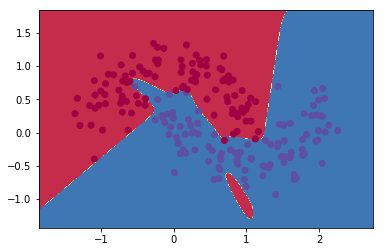

In [563]:
plot_decision_boundary(nn.predict)